In [1]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from math import atan2, degrees
import os
import cv2
from openslide import OpenSlide
from rotate_image import rotate_image
from matplotlib import pyplot as plt

In [2]:
#Load healthy tissue look up table (LUT)
LUT = r"\\fatherserverdw\kyuex\imlist_all.xlsx"
LUT = pd.read_excel(LUT)
# xmlist = LUT['filename'][(LUT['student score']>1) & (LUT['Block or Slide?']=="Both")]
LUThealthy = LUT[(LUT['student score']>1)]
LUThealthyback = LUThealthy[LUThealthy['body part 1'].str.lower()=="back"]
cntsrc = r'\\fatherserverdw\kyuex\clue images\hovernet_out\json'
dlsrc = r'\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined'
roisrc = r'\\fatherserverdw\kyuex\clue images\annotations\roi\labeledmask_20rsf'
def hasjson(row):
    fn,ext = os.path.splitext(row)
    return os.path.exists(os.path.join(cntsrc,fn+'.json'))
def hasdl(row):
    fn,ext = os.path.splitext(row)
    return os.path.exists(os.path.join(dlsrc,fn+'.tif'))
def hasroi(row):
    fn,ext = os.path.splitext(row)
    return os.path.exists(os.path.join(roisrc,fn+'.png'))
LUThealthyback['hasjson']=LUThealthyback['filename'].apply(lambda row: hasjson(row))
LUThealthyback['hasdl']=LUThealthyback['filename'].apply(lambda row: hasdl(row))
LUThealthyback['hasroi']=LUThealthyback['filename'].apply(lambda row: hasroi(row))
LUThealthyback2 = LUThealthyback[(LUThealthyback['hasjson']==True) & (LUThealthyback['hasdl']==True) & (LUThealthyback['hasroi']==True)]
LUThealthyback2 = LUThealthyback2.reset_index()
len(LUThealthyback2),len(LUThealthyback[(LUThealthyback['hasjson']==True)]),len(LUThealthyback[(LUThealthyback['hasdl']==True)]),len(LUThealthyback)

C:\Users\labuser\AppData\Local\Temp\ipykernel_18864\2170611798.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LUThealthyback['hasjson']=LUThealthyback['filename'].apply(lambda row: hasjson(row))
C:\Users\labuser\AppData\Local\Temp\ipykernel_18864\2170611798.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LUThealthyback['hasdl']=LUThealthyback['filename'].apply(lambda row: hasdl(row))
C:\Users\labuser\AppData\Local\Temp\ipykernel_18864\2170611798.py:21: SettingWithCopyWarning: 
A value is trying t

(53, 53, 66, 66)

In [4]:
cntsrc = r'\\fatherserverdw\kyuex\clue images\hovernet_out\json'
roisrc = r'\\fatherserverdw\kyuex\clue images\annotations\roi\labeledmask_20rsf'
wsisrc = r'\\fatherserverdw\kyuex\clue images'
dlsrc = r'\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined'
dst = r'\\fatherserverdw\kyuex\datadst\20220929'

row = LUThealthyback2.iloc[0]
fn,ext = os.path.splitext(row['filename'])
fn

'2022-06-07 14.27.44'

In [6]:
roi = Image.open(os.path.join(roisrc, '{}.{}'.format(fn, 'png')))  # roi is very small
roiarr = np.array(roi)
numsecmax = np.max(roiarr)
imcropdst = os.path.join(dst, 'imcrop')
dlcropdst = os.path.join(dst, 'dlcrop')
nuccropdst = os.path.join(dst, 'nuccrop')
if not os.path.exists(dst): os.mkdir(dst)
if not os.path.exists(imcropdst): os.mkdir(imcropdst)
if not os.path.exists(dlcropdst): os.mkdir(dlcropdst)
if not os.path.exists(nuccropdst): os.mkdir(nuccropdst)

dstfn = fn + 'sec{}'.format(numsecmax) + '.png'


mask = Image.open(os.path.join(dlsrc, '{}.{}'.format(fn, 'tif')))
ndpi = OpenSlide(os.path.join(wsisrc, '{}.{}'.format(fn, 'ndpi')))
json = pd.read_json(os.path.join(cntsrc, '{}.{}'.format(fn, 'json')), orient='index')

[x, y] = roi.size
(w, h) = ndpi.level_dimensions[0]
rsf = [w / x, h / y]
rsf = rsf[0]

json = pd.DataFrame(json[0].loc['nuc']).T.drop(columns=['type_prob'])
json = json[json['contour'].map(len) > 5].reset_index(drop=True)

def isinroi(row):
    newrow = [round(_ / 16) for _ in row]
    return roiarr[newrow[1], newrow[0]]
json['inroi'] = json['centroid'].apply(lambda row: isinroi(row))
jsoninroi = json[json['inroi'] > 0]

# create binary labeled mask of nuclei within roi
nuc_image = np.zeros((h, w), dtype=np.int32)  # need to flip h and w
for idx, ct in enumerate(jsoninroi['contour']):
    cv2.fillPoly(nuc_image, pts=[np.array(ct).astype(np.int32)], color=idx + 1)

# create DLmask within roi
mask_resized = mask.resize(roi.size, resample=0)  # nearest interpolation to rescale
DLsmall = np.array(mask_resized)
DLinroi = np.multiply(DLsmall, roiarr > 0)



minDermhole = 5000
minepisize = 1000
whitespace = 12

epi = (DLinroi == 1) | (DLinroi == 2)
derm = (2 < DLinroi) & (DLinroi < whitespace)
derm = remove_small_holes(derm, area_threshold=minDermhole)

epi2 = epi & ~derm
epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)


fns =[]
secNs =[]
drots =[]
bboxs=[]
bbox2s=[]

In [12]:
numsec=1
print('section N: ', numsec, '/', numsecmax)
roitmp = roiarr == numsec  # roitmp is logical, not greyscale
mskepi = roitmp & epi2
DLtmp = np.multiply(DLinroi, roitmp)  # roiscale

# create H&E
[xroi, yroi] = np.where(roitmp)
bboxroi = [np.min(xroi), np.max(xroi), np.min(yroi), np.max(yroi)]
roitmp2 = roitmp[bboxroi[0]:bboxroi[1], bboxroi[2]:bboxroi[3]]
bboxroi = [round(_*rsf) for _ in bboxroi]
# targetlevel = ndpi.get_best_level_for_downsample(rsf)
HE = ndpi.read_region(location=(bboxroi[0], bboxroi[2]), level=0, size=(bboxroi[1]-bboxroi[0],bboxroi[3]-bboxroi[2]))

section N:  1 / 1


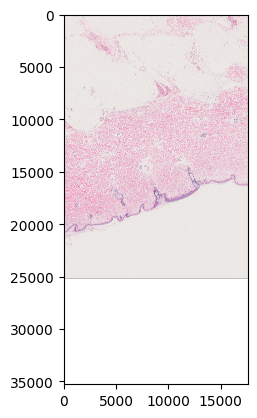

In [13]:
plt.imshow(HE)

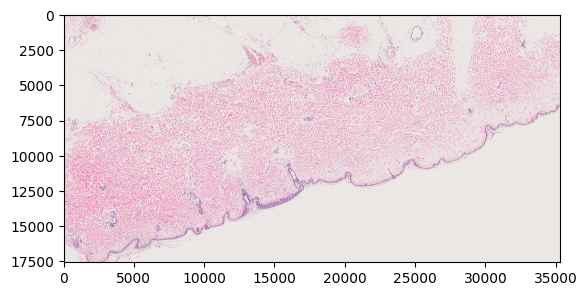

In [14]:
HE = ndpi.read_region(location=(bboxroi[2], bboxroi[0]), level=0, size=(bboxroi[3]-bboxroi[2],bboxroi[1]-bboxroi[0]))
plt.imshow(HE)

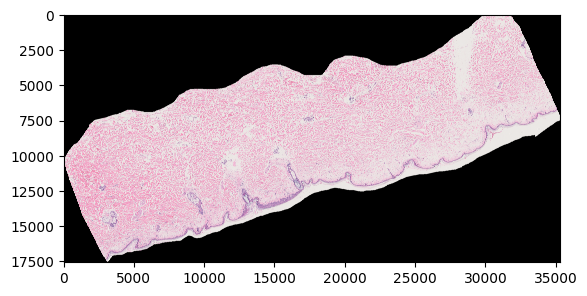

In [15]:
roitmp2 = cv2.resize(roitmp2.astype(np.uint8), dsize=HE.size, interpolation=cv2.INTER_NEAREST)
HEtmp = np.multiply(np.array(HE)[:, :, :3], np.repeat(roitmp2[:, :, np.newaxis], 3, axis=2))  # roiscale
plt.imshow(HEtmp)

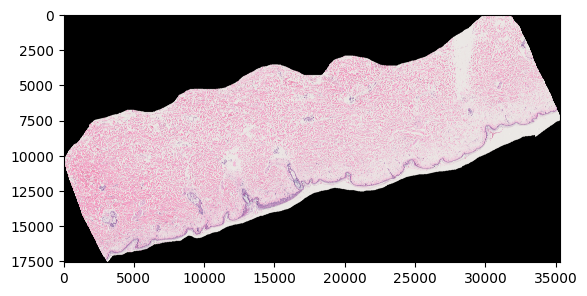

In [16]:
kernel = np.ones((5, 5), np.uint8)
roitmp3 = cv2.dilate(roitmp2, kernel, iterations=1)
HEtmp = np.multiply(np.array(HE)[:, :, :3], np.repeat(roitmp3[:, :, np.newaxis], 3, axis=2))  # roiscale
plt.imshow(HEtmp)

In [20]:
HEtmp.shape[:-1]

(17584, 35280)

In [2]:
from matplotlib import pyplot as plt
plt.imshow(DLrot)

NameError: name 'DLrot' is not defined

In [ ]:
DLrot = rotate_image(DLrot, d0)